<a href="https://colab.research.google.com/github/jrodenberg0/USTICC-2023-Project/blob/main/2022_USITCC_DEMO_(REGRESSION).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'usitcc-2022-project:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4392067%2F7542218%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240320%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240320T194500Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D7e0c9e1292d0d2dda2b9a6f47eb11134c48f9e6940a60a89b34d12141caa47af88a97cf13ccedfa5ae3ac923b0df13e64717930a2717a4f866665de52484a1cbf255ac945ad013aa80273746313350c4cfc3b56036e0a3fe7bda3495f2aaeab24e2c743a1bbec7cf3e76cea2091dc0ac371c08f09a8647e6de1b57683b7fe910bd6b47e5f80811fa691a520a67c1e8088e869519b43c34a4b1d0c90eb94c9aea41523900edc0a9f4600d3e2d5700b05118441802322b8a723151c7a409fcd462c7f59327174e166025b00c7edd19816975dbd5c51946c36d90406cfbd5bf319e5ac756be1fff643f3d31d5ddb704d49c04abe1f9a187f13ac896fa55f007efc8'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 4255471 bytes downloaded
Downloaded and uncompressed: usitcc-2022-project
Data source import complete.


In [2]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/usitcc-2022-project/Unemployment.xlsx
/kaggle/input/usitcc-2022-project/Education.xlsx
/kaggle/input/usitcc-2022-project/ERSCountyTypology2015Edition.xlsx
/kaggle/input/usitcc-2022-project/Food Environment Atlas-OKM.xlsx


Reading in and Preparing the data

Read in Data

In [4]:

ers = pd.read_excel(r'/kaggle/input/usitcc-2022-project/ERSCountyTypology2015Edition.xlsx',
                    header=3,
                    index_col='FIPStxt')

edu = pd.read_excel(r'/kaggle/input/usitcc-2022-project/Education.xlsx',
                    header=4,
                    index_col='Federal Information Processing Standards (FIPS) Code')

unemp = pd.read_excel(r'/kaggle/input/usitcc-2022-project/Unemployment.xlsx',
                      header=4,
                      index_col='FIPS_code')

In [5]:
#head
#edu.head(40)

#tail
#edu.tail(10)

#info
edu.info()

#describe

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3285 entries, 0 to 72153
Data columns (total 54 columns):
 #   Column                                                                    Non-Null Count  Dtype  
---  ------                                                                    --------------  -----  
 0   State                                                                     3285 non-null   object 
 1   Area name                                                                 3285 non-null   object 
 2   2003 Rural-Uban Continuum Code                                            3221 non-null   float64
 3   2003 Urban Influence Code                                                 3221 non-null   float64
 4   2013 Rural-Urban Continuum Code                                           3221 non-null   float64
 5   2013 Urban Influence Code                                                 3221 non-null   float64
 6   Less than a high school diploma, 1970                          

In [6]:
edu.isna().sum()

State                                                                        0
Area name                                                                    0
2003 Rural-Uban Continuum Code                                              64
2003 Urban Influence Code                                                   64
2013 Rural-Urban Continuum Code                                             64
2013 Urban Influence Code                                                   64
Less than a high school diploma, 1970                                       99
High school diploma only, 1970                                              99
Some college (1-3 years), 1970                                              99
Four years of college or higher, 1970                                       99
Percent of adults with less than a high school diploma, 1970                99
Percent of adults with a high school diploma only, 1970                     99
Percent of adults completing some college (1-3 years

In [7]:
edu = edu.dropna()

Data Transformation, light EDA

In [8]:
#dropping missing data across rows

unemp = unemp.drop(0,axis=0).copy()

In [9]:
unemp['county'] = unemp.Area_name.str.split(',',expand=True)[0]

unemp = unemp.fillna(0)

unemp = unemp.drop('Area_name',axis=1).copy()

In [10]:
lemp = pd.wide_to_long(unemp,
                stubnames=['Civilian_labor_force',
                            'Employed',
       'Unemployed',
       'Unemployment_rate',
       'Median_Household_Income',
       'Med_HH_Income_Percent_of_State_Total'],
                i=['State','county',
                   'Rural_urban_continuum_code_2013',
                   'Urban_influence_code_2013',
       'Metro_2013'],
                j='Year',
                sep='_').reset_index()

In [11]:
lemp = lemp.drop(['Rural_urban_continuum_code_2013',
           'Urban_influence_code_2013',
           'Metro_2013'],axis=1).sort_values(by=['Year','State','county'])

In [12]:
lemp.loc[~lemp[['Median_Household_Income',
      'Med_HH_Income_Percent_of_State_Total']].isna().any(axis=1)]['Year'].describe()

#only not NA when year is 2020

count    3276.0
mean     2020.0
std         0.0
min      2020.0
25%      2020.0
50%      2020.0
75%      2020.0
max      2020.0
Name: Year, dtype: float64

In [13]:
r = lemp.groupby(['Year','State'])\
    .Unemployment_rate.mean()\
        .reset_index().round(2)


import plotly.express as px

px.line(r, x='Year',y='Unemployment_rate',color='State',title='Unemployment Rate by Year-State Combo')


In [14]:
px.box(r,x='Year',y='Unemployment_rate',title='Distribution of Unemployment Rate by Year',hover_data=['State'])

PART 1: Descriptive Statistics

In [15]:
gc_unemp = lemp[(lemp.county == 'Greene County')
     & (lemp.State == 'MO')]['Unemployment_rate'].mean().round(2)


print(f'Unemployment Rate for Greene County, MO is {gc_unemp}%')

Unemployment Rate for Greene County, MO is 4.67%


In [16]:
mo_unemp = lemp.groupby('State')['Unemployment_rate']\
    .mean()['MO'].round(2)

if mo_unemp < gc_unemp:
    print('Greene County has greater average unemployment')

else:
    print('Missouri has greate average unemployment')

Missouri has greate average unemployment


In [17]:
tn_counties = lemp.groupby(['State'])['county'].nunique()['TN']

print(f'Number of Counties in TN is: {tn_counties}')

Number of Counties in TN is: 96


In [18]:
edu.query('State == "AK"')\
    ["Percent of adults with a bachelor's degree or higher 2016-20"]\
        .agg(stddev_adults_with_bachelors = np.std,
             average_adults_with_bachelors = np.mean).round(2)

stddev_adults_with_bachelors      9.51
average_adults_with_bachelors    23.00
Name: Percent of adults with a bachelor's degree or higher 2016-20, dtype: float64

Part 2: Comparing two groups

In [19]:
okm = ['OK','KY','MS']

amt = ['AR','MO','TN']

okm_df = edu.query('State == @okm')

amt_df = edu.query('State == @amt')

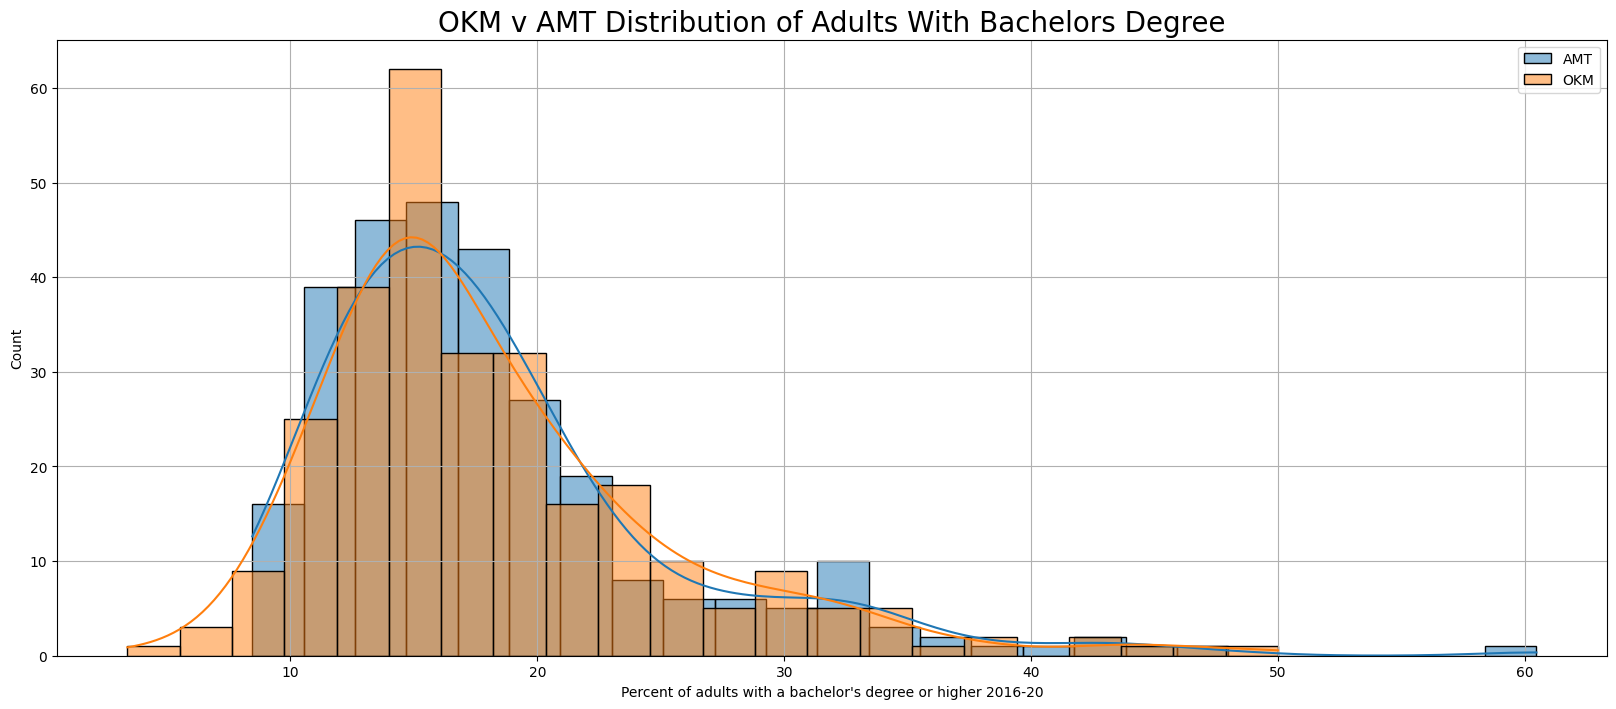

AMT Subset 5 Number Summary count    285.000000
mean      18.237290
std        7.414745
min        8.456083
25%       13.453461
50%       16.422331
75%       20.557512
max       60.461533
Name: Percent of adults with a bachelor's degree or higher 2016-20, dtype: float64
OKM Subset 5 Number Summary count    279.000000
mean      18.189692
std        7.178862
min        3.396603
25%       13.804267
50%       16.117834
75%       20.754005
max       49.996426
Name: Percent of adults with a bachelor's degree or higher 2016-20, dtype: float64


In [20]:
plt.figure(figsize=(20,8))

sns.histplot(data = amt_df,
             x = "Percent of adults with a bachelor's degree or higher 2016-20",
             kde=True,
             label='AMT')

sns.histplot(data = okm_df,
             x = "Percent of adults with a bachelor's degree or higher 2016-20",
             kde=True,
             label='OKM')

plt.legend()

plt.grid()

plt.title('OKM v AMT Distribution of Adults With Bachelors Degree',fontsize=20)

plt.show()

amt_5 = amt_df["Percent of adults with a bachelor's degree or higher 2016-20"].describe()

print(f"AMT Subset 5 Number Summary {amt_5}")

okm_5 = okm_df["Percent of adults with a bachelor's degree or higher 2016-20"].describe()

print(f"OKM Subset 5 Number Summary {okm_5}")

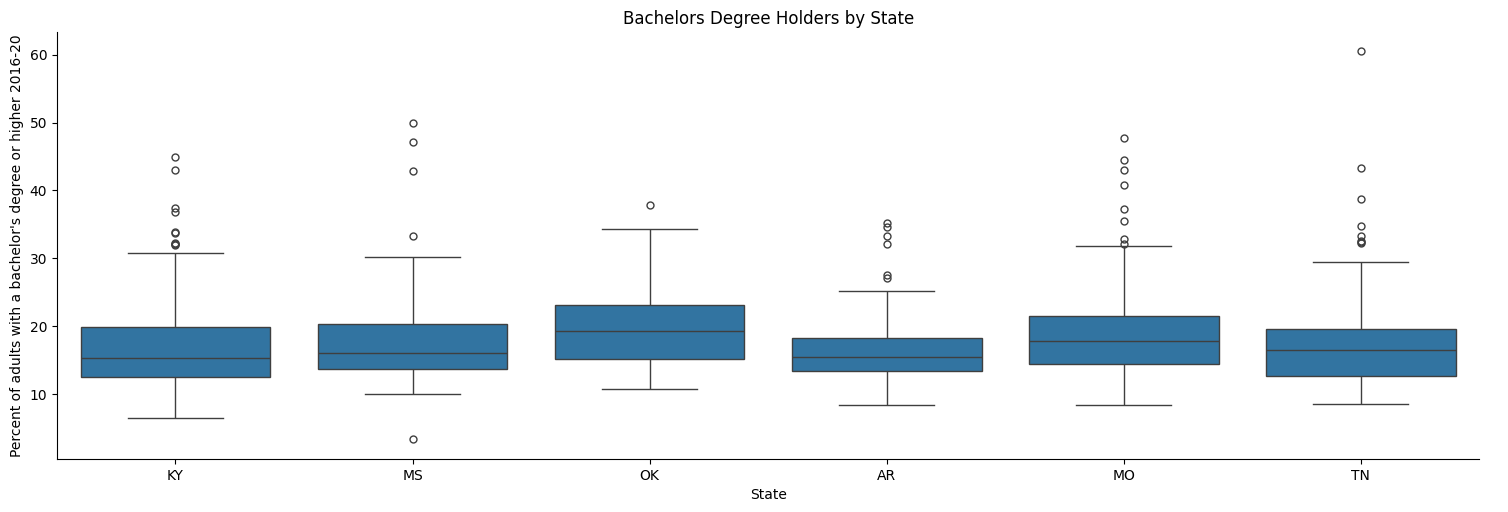

In [21]:

cat = pd.concat([okm_df,amt_df])

sns.catplot(cat,
            x='State',
            y="Percent of adults with a bachelor's degree or higher 2016-20",
            kind='box',
            aspect=3)

plt.title('Bachelors Degree Holders by State')

plt.show()

In [22]:
if amt_5['mean'] > okm_5['mean']:

    print('AMT Subset has higher % of Degree Holders.')

else:
    print('OKM Subset Has Higher Percentage of Degree Holders.')

print(f'AMT Average :{amt_5["mean"].round(2)}%, OKM Average :{okm_5["mean"].round(2)}%',"\n")

AMT Subset has higher % of Degree Holders.
AMT Average :18.24%, OKM Average :18.19% 



In [23]:
amt_df = amt_df\
    .merge(lemp['Unemployment_rate'],
           how='left',
           left_index=True,right_index=True)


okm_df = okm_df\
    .merge(lemp['Unemployment_rate'],
           how='left',
           left_index=True,right_index=True)

In [24]:
okm_corr = okm_df[["Percent of adults with a bachelor's degree or higher 2016-20"
        ,"Unemployment_rate"]].corr()['Unemployment_rate'][0].round(3)


amt_corr = amt_df[["Percent of adults with a bachelor's degree or higher 2016-20"
        ,"Unemployment_rate"]].corr()['Unemployment_rate'][0].round(3)

print(f'OKM Correlation {okm_corr}')

print(f'AMT Correlation {amt_corr}')

OKM Correlation -0.014
AMT Correlation -0.008


Plotting the subsets.

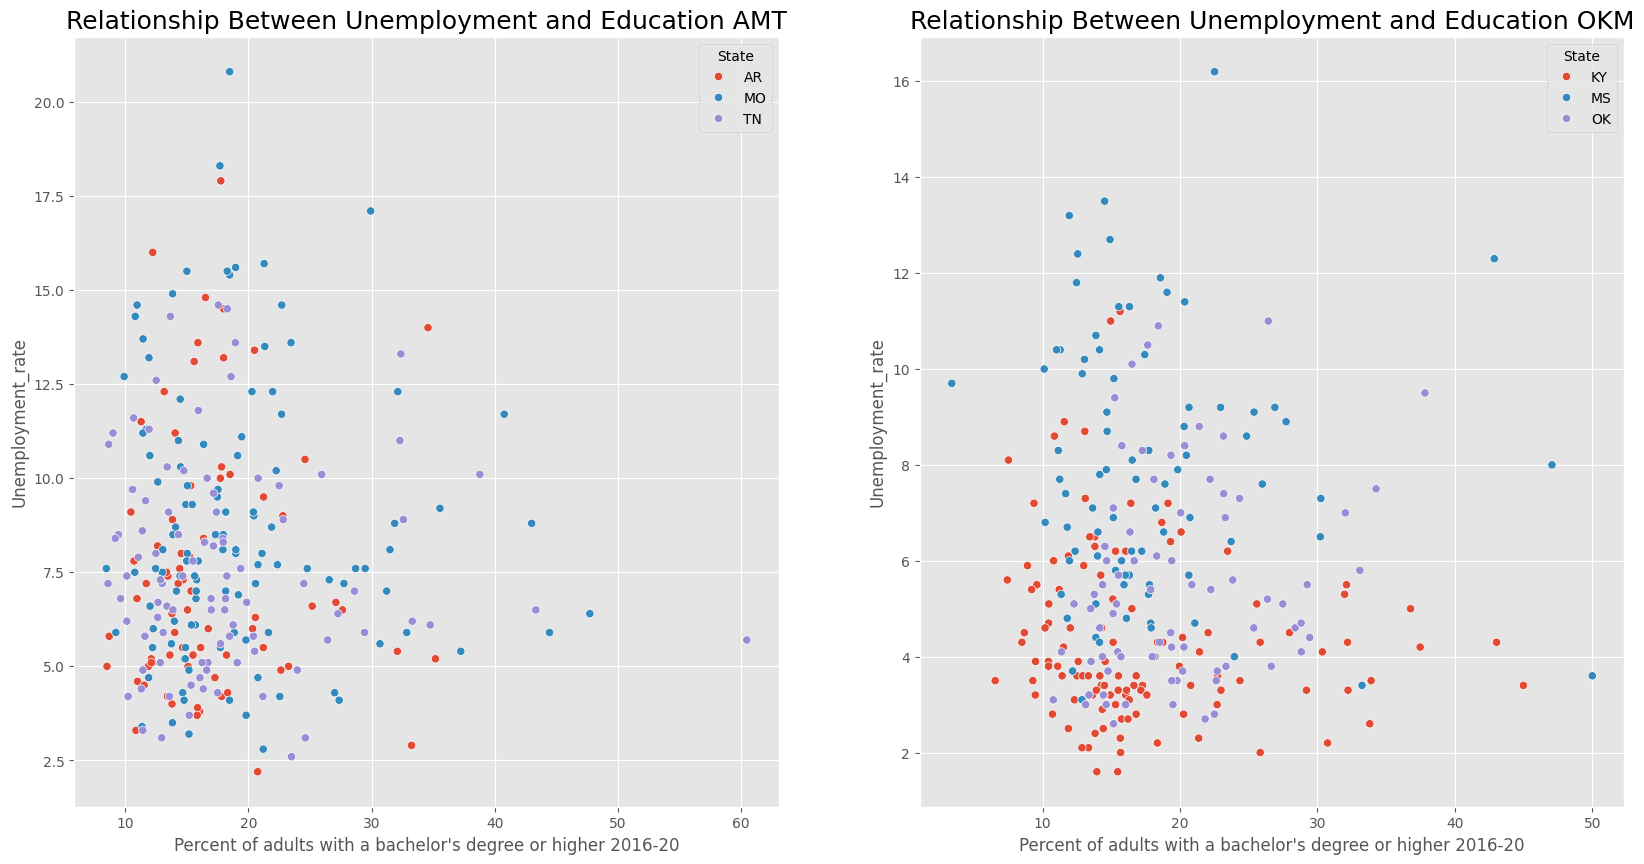

In [25]:
plt.style.use('ggplot')

fig, ax = plt.subplots(ncols =2,figsize=(20,10))

sns.scatterplot(amt_df, x = "Percent of adults with a bachelor's degree or higher 2016-20",
                    y = "Unemployment_rate",
                    hue='State',
                    ax=ax[0])

sns.scatterplot(okm_df, x = "Percent of adults with a bachelor's degree or higher 2016-20",
                    y = "Unemployment_rate",
                    hue='State',
                    ax=ax[1])

ax[1].set_title('Relationship Between Unemployment and Education OKM',fontsize=18)

ax[0].set_title('Relationship Between Unemployment and Education AMT',fontsize=18)

plt.show()

Using a loop instead

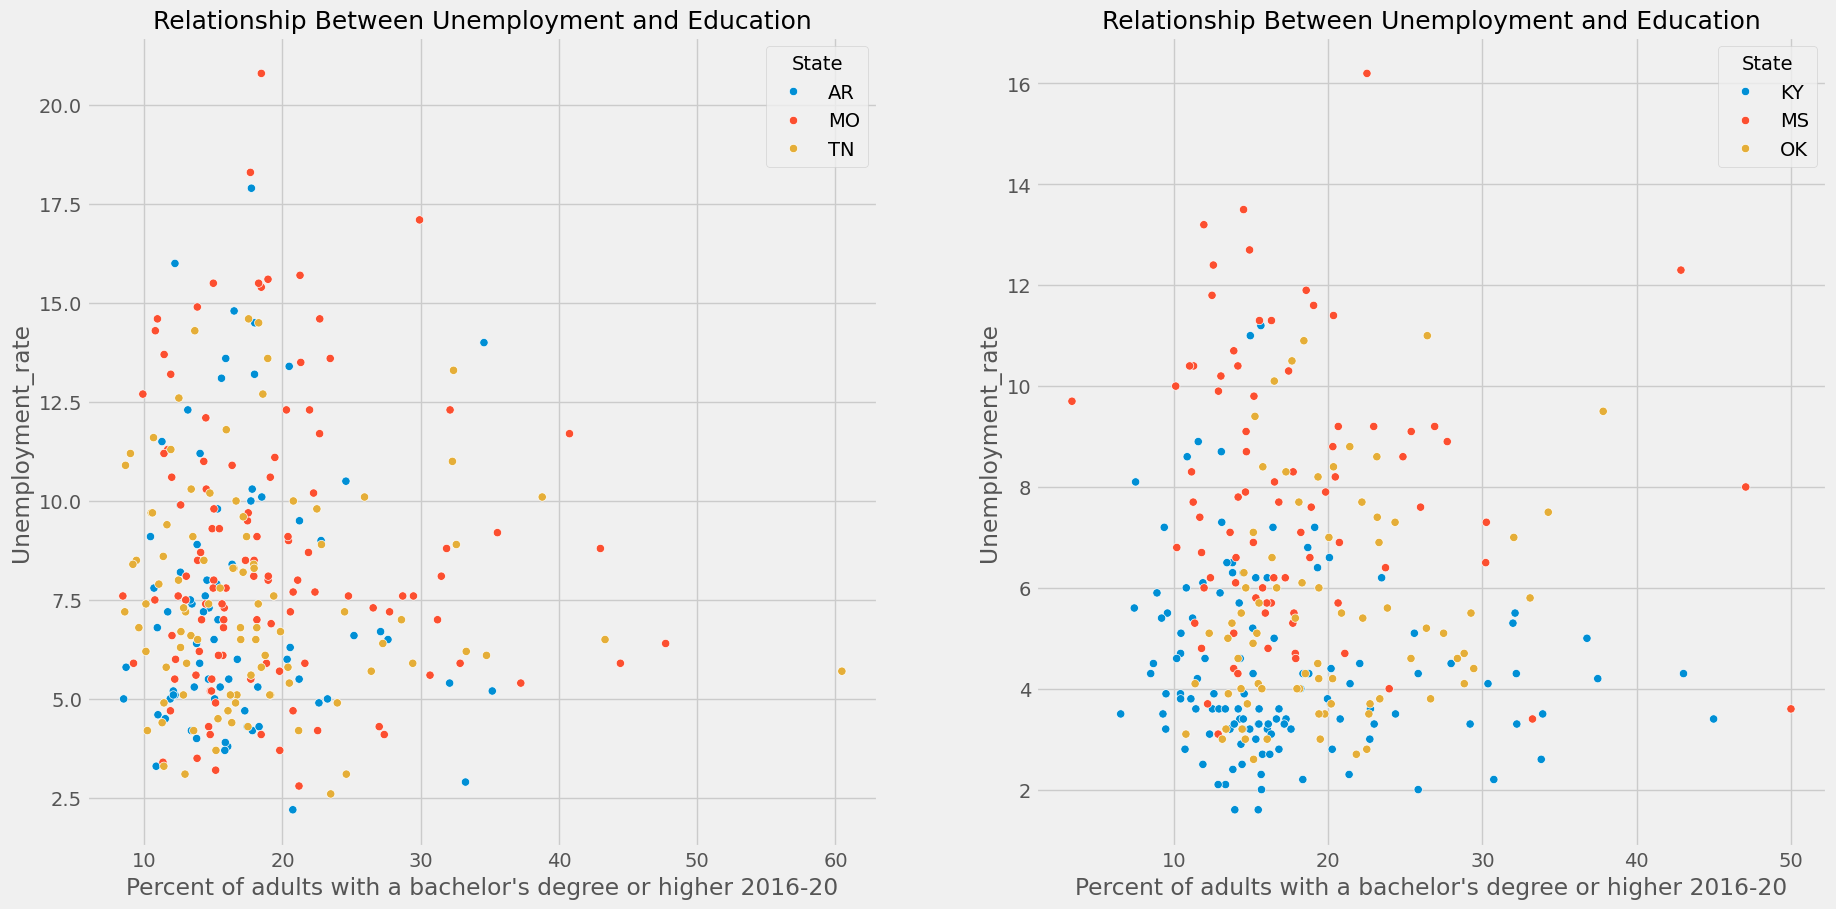

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')

# List of dataframes
dataframes = [amt_df, okm_df]

# Create a 1x2 subplot grid
fig, ax = plt.subplots(ncols=2, figsize=(20, 10))

# Iterate over dataframes and subplot axes
for i, df in enumerate(dataframes):
    sns.scatterplot(data=df, x="Percent of adults with a bachelor's degree or higher 2016-20",
                    y="Unemployment_rate",
                    hue='State',
                    ax=ax[i])

    ax[i].set_title(f'Relationship Between Unemployment and Education', fontsize=18)

plt.show()


Defining Z Scores, for fun lets check if variables are normally distributed. This is important information, zscores are less effective on HIGHLY skewed variables.

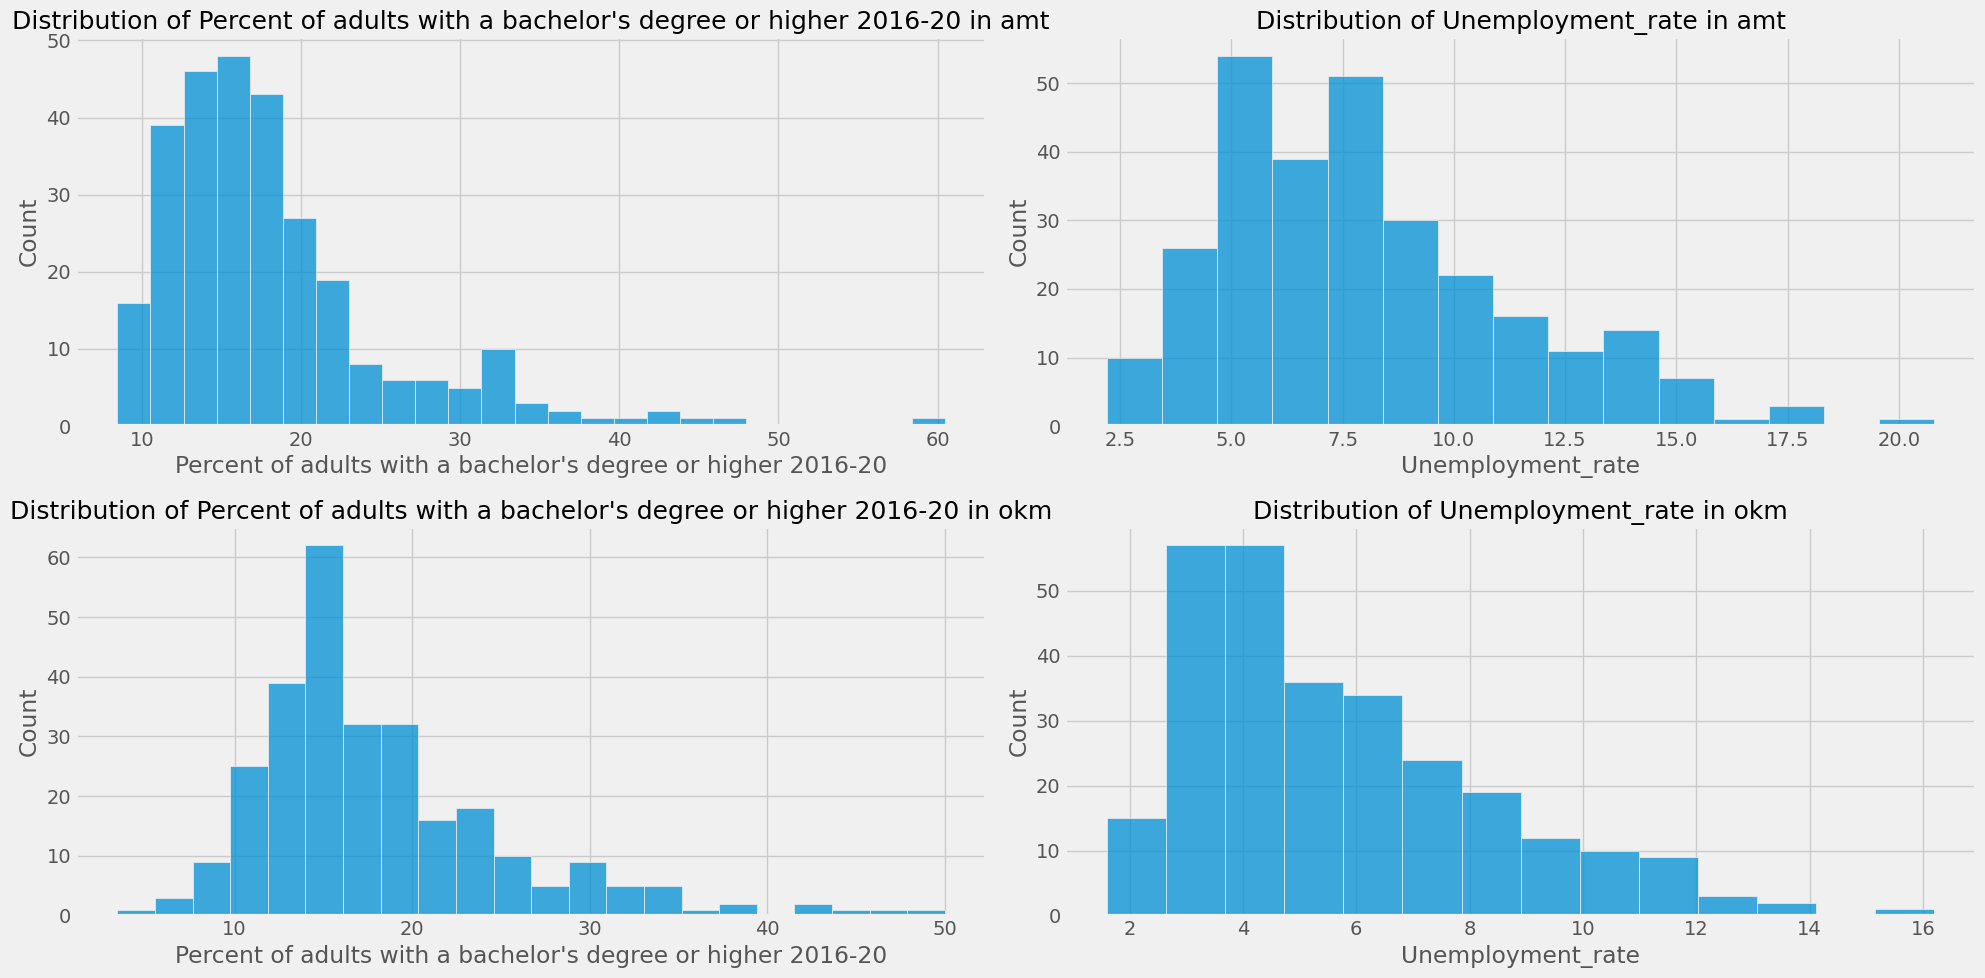

In [27]:
cols = ["Percent of adults with a bachelor's degree or higher 2016-20",
                    "Unemployment_rate"]

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')

# List of dataframes
dataframes = [amt_df, okm_df]

amt_df.name = 'amt'

okm_df.name = 'okm'

# Create a 1x2 subplot grid
fig, ax = plt.subplots(nrows =2, ncols=2, figsize=(20, 10))

# Iterate over dataframes and subplot axes
for i, df in enumerate(dataframes):

    for j, col in enumerate(cols):

        sns.histplot(data=df,
                     x=col,
                        ax=ax[i,j])

        ax[i,j].set_title(f'Distribution of {col} in {df.name}', fontsize=18)

plt.tight_layout()

plt.show()


Easy Z Score creation using a nested loop

In [28]:
from scipy.stats import zscore

cols = ["Percent of adults with a bachelor's degree or higher 2016-20",
                    "Unemployment_rate"]

# List of dataframes
dataframes = [amt_df, okm_df]

# Iterate over dataframes and subplot axes
for df in dataframes:

    for col in cols:
        df[f'z_of_{col}'] = zscore(df[col])


Dropping outliers using absolute Z-score value > 3 (adjust threshold on business need, 3 is best practice for most cases.)

In [29]:
amt_out = (amt_df["z_of_Percent of adults with a bachelor's degree or higher 2016-20"].abs() > 3) | (amt_df["z_of_Unemployment_rate"].abs() > 3)

okm_out = (okm_df["z_of_Percent of adults with a bachelor's degree or higher 2016-20"].abs() > 3) | (okm_df["z_of_Unemployment_rate"].abs() > 3)

amt_df_ = amt_df.loc[~amt_out]

okm_df_ = okm_df.loc[~okm_out]

print(f'OKM Subset Outliers Dropped: {okm_df.shape[0] - okm_df_.shape[0]}')

print(f'AMT Subset Outliers Dropped: {amt_df.shape[0] - amt_df_.shape[0]}')

OKM Subset Outliers Dropped: 6
AMT Subset Outliers Dropped: 9


Read in the Target Data and Prepare for modeling

In [30]:
food = pd.read_excel(r'/kaggle/input/usitcc-2022-project/Food Environment Atlas-OKM.xlsx',
              sheet_name='STORES',
              index_col='FIPS')

Using .merge to join on indices and pulling in Z-scores of variables, this is due these variables already being scaled!

In [31]:
#build dataset for modeling

okm_df = okm_df_[["z_of_Percent of adults with a bachelor's degree or higher 2016-20",
         "z_of_Unemployment_rate"]]\
             .merge(food['SNAPSPTH17'],
                    left_index=True,
                    right_index=True,
                    how='inner').merge(ers[['Persistent_Poverty_2013',
                                            'Metro-nonmetro status, 2013 0=Nonmetro 1=Metro']],
                                            right_index=True,
                                            left_index=True,
                                            how='left')


amt_df = amt_df_[["z_of_Percent of adults with a bachelor's degree or higher 2016-20",
         "z_of_Unemployment_rate"]]\
                .merge(ers[['Persistent_Poverty_2013',
                                            'Metro-nonmetro status, 2013 0=Nonmetro 1=Metro']],
                                            right_index=True,
                                            left_index=True,
                                            how='inner')

Splitting the data for OKM to ensure we train a robust model.

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, ElasticNet, LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

def train_test_score(df):

    target = 'SNAPSPTH17'

    X = df.drop(target, axis=1)
    y = df[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

    models = {'Ridge': Ridge(),
              'XGBoost': XGBRegressor(),
              'SVR': SVR(),
              'ElasticNet': ElasticNet(),
              'RandomForest': RandomForestRegressor(),
              'AdaBoost': AdaBoostRegressor(base_estimator=LinearRegression())}

    model_results = {}  # Dictionary to store model results

    for model_name, model in models.items():
        model.fit(X_train, y_train)  # Train models

        # Make Predictions
        y_train_preds = model.predict(X_train)
        y_test_preds = model.predict(X_test)

        # Training Set Performance
        model_r2_train = r2_score(y_train, y_train_preds)
        model_r2_test = r2_score(y_test, y_test_preds)

        model_rmse_train = np.sqrt(mean_squared_error(y_train, y_train_preds))
        model_rmse_test = np.sqrt(mean_squared_error(y_test, y_test_preds))

        # Store results in the dictionary
        model_results[model_name] = {
            'R^2 Score (Training)': model_r2_train,
            'RMSE (Training)': model_rmse_train,
            'R^2 Score (Testing)': model_r2_test,
            'RMSE (Testing)': model_rmse_test
        }

    # Sort the models by RMSE on the test set
    sorted_models = {k: v for k, v in sorted(model_results.items(), key=lambda item: item[1]['RMSE (Testing)'])}

    return sorted_models


#training and scoring various models on OKM subset.

results = train_test_score(okm_df)

# Display the sorted models
for model_name, metrics in results.items():
    print(f"\nPerformance for {model_name} Model:")
    print("Training Set Performance:")
    print(f"  R^2 Score (Training): {metrics['R^2 Score (Training)']:.4f}")
    print(f"  RMSE (Training): {metrics['RMSE (Training)']:.4f}")
    print("\nTesting Set Performance:")
    print(f"   R^2 Score (Testing): {metrics['R^2 Score (Testing)']:.4f}")
    print(f"   RMSE (Testing): {metrics['RMSE (Testing)']:.4f}")



Performance for Ridge Model:
Training Set Performance:
  R^2 Score (Training): 0.4668
  RMSE (Training): 0.2127

Testing Set Performance:
   R^2 Score (Testing): 0.1925
   RMSE (Testing): 0.3057

Performance for AdaBoost Model:
Training Set Performance:
  R^2 Score (Training): 0.4672
  RMSE (Training): 0.2127

Testing Set Performance:
   R^2 Score (Testing): 0.1820
   RMSE (Testing): 0.3076

Performance for SVR Model:
Training Set Performance:
  R^2 Score (Training): 0.5543
  RMSE (Training): 0.1945

Testing Set Performance:
   R^2 Score (Testing): 0.0786
   RMSE (Testing): 0.3265

Performance for RandomForest Model:
Training Set Performance:
  R^2 Score (Training): 0.8945
  RMSE (Training): 0.0947

Testing Set Performance:
   R^2 Score (Testing): 0.0620
   RMSE (Testing): 0.3294

Performance for ElasticNet Model:
Training Set Performance:
  R^2 Score (Training): 0.0000
  RMSE (Training): 0.2914

Testing Set Performance:
   R^2 Score (Testing): -0.0017
   RMSE (Testing): 0.3405

Perfo

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning:

`base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.



In [33]:
#define scorer function

from sklearn.metrics import mean_absolute_error, mean_squared_error

def kpi_ML(y_train,y_train_pred,y_test,y_test_pred, name=''):

    df = pd.DataFrame(columns=['MAE','RMSE'],
                      index=['Train','Test'])

    df.index.name = name

    #Train Metrics MAE, RMSE
    df.loc['Train','MAE'] =  mean_absolute_error(y_train,y_train_pred)
    df.loc['Train','RMSE'] =  np.sqrt(mean_squared_error(y_train,y_train_pred))

    #Test Metrics MAE, RMSE
    df.loc['Test','MAE'] =  mean_absolute_error(y_test,y_test_pred)
    df.loc['Test','RMSE'] =  np.sqrt(mean_squared_error(y_test,y_test_pred))

    df = df.astype(float).round(3)

    print(df)


Fitting a baseline linear model

In [34]:
linreg = LinearRegression()


#define target variable (this is our Y)
target = 'SNAPSPTH17'


#create x and y arrays

X = okm_df.drop(target, axis=1)

y = okm_df[target]

#fit linear model

linreg.fit(X,y)

#linear_preds_train = linreg.predict(X_train)

#linear_preds_test = linreg.predict(X_test)

LinearRegression()

In [35]:

coef_df = pd.DataFrame(list(zip(X.columns,
                                linreg.coef_)),
                       columns=['Feature','Coefficient'])


coef_df


,Feature,Coefficient
0,z_of_Percent of adults with a bachelor's degre...,-0.055217
1,z_of_Unemployment_rate,-0.013452
2,Persistent_Poverty_2013,0.291002
3,"Metro-nonmetro status, 2013 0=Nonmetro 1=Metro",-0.135338


In [36]:
amt_df['amt_preds'] = linreg.predict(amt_df)

In [37]:
amt_final = amt_df\
    .sort_values(by='amt_preds',ascending=False)\
    .merge(amt_df_[['State','Area name']],
                                         left_index=True,
                                         right_index=True)

In [38]:
amt_final

,z_of_Percent of adults with a bachelor's degree or higher 2016-20,z_of_Unemployment_rate,Persistent_Poverty_2013,"Metro-nonmetro status, 2013 0=Nonmetro 1=Metro",amt_preds,State,Area name
5077,-1.290188,-0.665712,1,0,1.362623,AR,Lee County
5123,-0.995979,-1.425109,1,0,1.356593,AR,St. Francis County
47029,-0.937792,-1.090974,1,0,1.348886,TN,Cocke County
47151,-1.223588,0.124062,1,0,1.348322,TN,Scott County
47095,-1.096090,-0.179697,1,0,1.345368,TN,Lake County
...,...,...,...,...,...,...,...
29095,1.875920,1.308721,0,1,0.734903,MO,Jackson County
47157,1.909690,1.612480,0,1,0.728952,TN,Shelby County
29051,2.338648,0.367069,0,1,0.722019,MO,Cole County
5007,2.207194,1.825111,0,1,0.709664,AR,Benton County
